### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [52]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

In [53]:
# Imports
import numpy as np
import imageio.v3 as iio
import random


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [54]:
# Global variables
POPULATION_SIZE = 40
IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


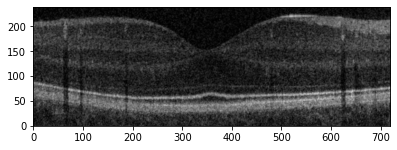

In [55]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [56]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)
    
    def cost_internal(self, bg_colour):
        cost_size = 1 / (self.r + 0.01)
        cost_shape = self.dr + abs(self.dgamma)
        cost_colour = abs(self.colour - bg_colour)
        return cost_size + cost_shape + cost_colour

    def cost_group(self, other_worms, preferred_distance=50):
        cost_group = 0
        for worm in other_worms:
            distance = np.sqrt((self.x - worm.x) ** 2 + (self.y - worm.y) ** 2)
            if distance < preferred_distance:
                cost_group += (preferred_distance - distance) ** 2
        return cost_group

    def cost_environmental(self, image, radius=5):
        xmin = max(0, int(round(self.x - radius)))
        xmax = min(image.shape[1], int(round(self.x + radius)))
        ymin = max(0, int(round(self.y - radius)))
        ymax = min(image.shape[0], int(round(self.y + radius)))
        local_area = image[ymin:ymax, xmin:xmax]
        local_intensity = np.mean(local_area) / 255.0
        return abs(self.colour - local_intensity)

    def calculate_total_cost(self, population, image):
        bg_colour = image[int(self.y), int(self.x)] / 255.0
        internal_cost = self.cost_internal(bg_colour)
        group_cost = self.cost_group([worm.worm for worm in population if worm.worm != self])
        environmental_cost = self.cost_environmental(image)
        return 2* internal_cost + 2 * group_cost + 3 * environmental_cost

In [57]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [58]:
class Individual(object):
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.fitness = float('inf')
        self.worm = Camo_Worm(*self.chromosome) 

    def get_worm(self):
        return self.worm 

    @classmethod
    def create_gnome(cls, imshape, init_params):
        return random_worm(imshape, init_params)

    def cal_fitness(self, population, image):
        self.fitness = 1 / (1 + self.worm.calculate_total_cost(population, image))

    def mate(self, partner):
        child_chromosome1 = []
        child_chromosome2 = []
        for gp1, gp2 in zip(self.chromosome, partner.chromosome):
            prob = random.random()
            if prob < 0.45:
                child_chromosome1.append(gp1)
                child_chromosome2.append(gp2)
            elif prob < 0.90:
                child_chromosome1.append(gp2)
                child_chromosome2.append(gp1)
            else:
                child_chromosome1.append(random.uniform(0, 1))
                child_chromosome2.append(random.uniform(0, 1))
        return Individual(child_chromosome1), Individual(child_chromosome2)

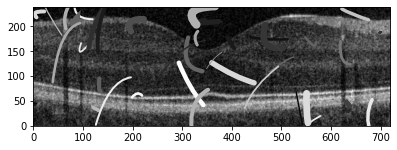

In [59]:
def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return [midx, midy, r, theta, dr, dgamma, width, colour]

def initialise_clew(size, imshape, init_params):
    clew = []
    for i in range(size):
        chromosome = random_worm(imshape, init_params)
        individual = Individual(chromosome)
        clew.append(individual.get_worm()) 
    return clew


clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

Running generation 1 of 100


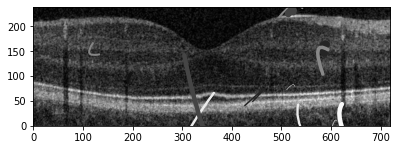

Generation 1 has 20 worms
Running generation 2 of 100


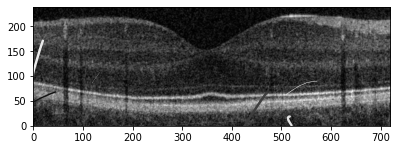

Generation 2 has 10 worms
Running generation 3 of 100


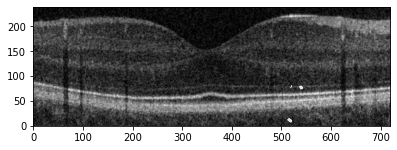

Generation 3 has 5 worms
Running generation 4 of 100


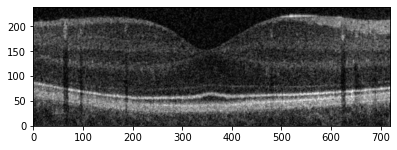

Generation 4 has 2 worms
Running generation 5 of 100


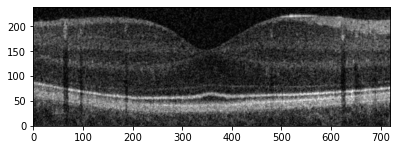

Generation 5 has 1 worms
Running generation 6 of 100


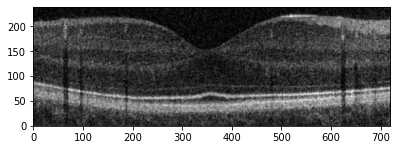

Generation 6 has 0 worms
Running generation 7 of 100
No valid fitness values in population


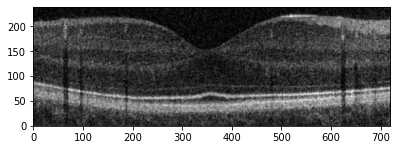

In [60]:

def genetic_algorithm(image, initial_params, population_size, generations):
    population = [Individual(random_worm(image.shape, initial_params)) for _ in range(population_size)]
    costs = []  

    for generation in range(generations):
        print(f"Running generation {generation + 1} of {generations}") 
        for individual in population:
            individual.cal_fitness(population, image)
            if not np.isfinite(individual.fitness):
                print(f"Invalid fitness for individual: {individual.chromosome}")

        if termination_condition_met(population):
            break
        generation_costs = [individual.fitness for individual in population]
        if not generation_costs:
            print("No valid fitness values in population")
            break
        min_cost = min(generation_costs) 
        costs.append(1 / min_cost - 1)  

        population = select_best_individuals(population)
        
        new_generation = create_next_generation(population)
        
        population = new_generation

        #if generation % 10 == 0:
        visualize_population([ind.worm for ind in population], image)
        print(f"Generation {generation + 1} has {len(population)} worms")
    return population
            


def termination_condition_met(population):
    return any(individual.fitness >= 0.9 for individual in population)

def select_best_individuals(population):
    population.sort(key=lambda x: x.fitness, reverse=True)
    return population[:int(0.5 * len(population))]  

def create_next_generation(population):
    new_generation = []
    while len(new_generation) < len(population):
        parent1 = random.choice(population)
        parent2 = random.choice(population)
        child1, child2 = parent1.mate(parent2)
        if child1 is None or child2 is None:
            print(f"Failed to create child from parents: {parent1.chromosome}, {parent2.chromosome}")
            continue
        new_generation.extend([child1, child2])
    return new_generation[:len(population)]


def visualize_population(worms, image):
    drawing = Drawing(image)
    drawing.add_worms(worms)  
    drawing.show()

optimized_clew = genetic_algorithm(image, (40, 30, 1), 40, 100) 

drawing = Drawing(image)
drawing.add_worms([ind.get_worm() for ind in optimized_clew]) 
drawing.show()
            



&copy; Cara MacNish, UWA, 2024